<a href="https://colab.research.google.com/github/yl-code-it/MIGWeldDefectClassification/blob/main/Machine_Learning_Term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning 3253 - Term Project 
# **Classifying Good/Bad Weld Images using Transfer Learning in Keras**
# Yu Lin, Soumitra Dinda, Senda Chinganzi, and Qi (Quincy) Zhang

1- Upload local weld images into Colab by choosing the zipped folder. This dataset has 2 classes (Good, and Bad). Images for each class are stored in its own folder.

2- The images have dimensions of 576x300, 8-bit depth, .BMP format. Resize all of them to 150x150.

3- Split images to 75-25% for training and test. Make sure you have the same distribution of Good/Bad weld  types between train and test datasets.

4- Baseline model - DNN without convolution/pooling feature extraction layers

5- Use a VGG16 model (pre-trained on ImageNet)

  5.1- Remove the top layers (fully connected layers)

  5.2- Add your own fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 2 nodes (2 classes - Good/Bad welds) and ‘softmax’ activation)

  5.3- First, freeze all layers of VGG16, train (fine-tune) and evaluate the model. You need to pick the right hyper-parameters for your training (try with different ones)

  5.4- Second, unfreeze the last block of VGG16 (block5), re-train and evaluate the model

  5.5- Third, unfreeze all the layers and try again.

6- Compare the accuracy you got in both cases . Which one is better and why?

In [1]:
import os
import numpy as np
import PIL
import PIL.Image
from tqdm import tqdm
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import load_model
from keras.models import Model
from tensorflow.keras import applications
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from xgboost import XGBClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

# 1- Upload local weld images into Colab by choosing the zipped folder. This dataset has 2 classes (Good, and Bad). Images for each class are stored in its own folder.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ML3253.zip to ML3253.zip


# Extract zipped folder

In [3]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['ML3253.zip']), 'r')
data.extractall()

# Understand the datasets by printing out the directory. 
# All are BMP format images with same size. 

In [4]:
data.printdir()

File Name                                             Modified             Size
BAD/                                           2022-03-12 17:20:20            0
BAD/Img_SRRH_13_1_17_22.37.04_MIG16.BMP        2022-01-13 05:32:24       173878
BAD/Img_SRRH_17_1_80_07.34.35_MIG16.BMP        2022-01-17 12:30:06       173878
BAD/Img_SRRH_17_3_29_22.56.18_MIG16.BMP        2022-01-17 03:51:48       173878
BAD/Img_SRRH_17_3_6_20.22.05_MIG16.BMP         2022-01-17 01:17:34       173878
BAD/Img_SRRH_18_1_74_06.42.42_MIG16.BMP        2022-01-18 11:38:16       173878
BAD/Img_SRRH_18_1_75_06.47.13_MIG16.BMP        2022-01-18 11:42:46       173878
BAD/Img_SRRH_18_1_76_06.53.03_MIG16.BMP        2022-01-18 11:48:36       173878
BAD/Img_SRRH_18_1_77_06.57.01_MIG16.BMP        2022-01-18 11:52:34       173878
BAD/Img_SRRH_18_2_7_11.17.43_MIG16.BMP         2022-01-18 16:13:16       173878
BAD/Img_SRRH_18_3_22_21.25.03_MIG16.BMP        2022-01-18 02:20:36       173878
BAD/Img_SRRH_18_3_30_21.57.46_MIG16.BMP 

# Set image folder directories. 
# check numbers of images for both GOOD - 900 and BAD - 108. 
# We know it is imbalanced with only roughly 10% of all combined images are BAD welds. In reality, industry always thrives to produce OK quality parts with GOOD welds. 

In [5]:
target_names = ["Good", "Bad"]
Good_data_dir = '/content/GOOD'
Bad_data_dir = '/content/BAD'
nb_good_samples = sum([len(files) for _, _, files in os.walk(Good_data_dir)])
nb_bad_samples = sum([len(files) for _, _, files in os.walk(Bad_data_dir)])
print('\n - names of label (Binary): ', target_names)
print(' - # of GOOD WELD samples: ', nb_good_samples, '\n - # of BAD WELD samples: ', nb_bad_samples)


 - names of label (Binary):  ['Good', 'Bad']
 - # of GOOD WELD samples:  900 
 - # of BAD WELD samples:  108


# 2 - Preprocessing Data Sets
# Append all images into X with labels (y)
# Resize all of images to 150x150.
# The images have dimensions of 576x300, 8-bit depth, .BMP format. 

In [6]:
def assigning_label(img,weld_type):
    return weld_type

def make_train_data(weld_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assigning_label(img,weld_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        y.append(str(label))

np.random.seed(45)
tf.random.set_seed(45)
X=[]
y=[]
IMG_SIZE=150

# Transform non-numerical labels (GOOD/BAD) to numerical labels.
# Further converts a class vector (integers) to binary class matrix using Keras utility - to_categorical(y,2), 2 means just two classes - GOOD/BAD
# Nomalized X into 0~1 range by dividing 255, which is max value in pixels

In [7]:
#create training data
make_train_data('Good',Good_data_dir)
make_train_data('Bad',Bad_data_dir)
print(len(X))

labelEncoder=LabelEncoder()
y=labelEncoder.fit_transform(y)
y=to_categorical(y,2)
X=np.array(X)
X=X/255

100%|██████████| 108/108 [00:00<00:00, 1144.94it/s]


1008


# 3 - Split images to 75-25% for training and test. Make sure you have the same distribution of Good/Bad weld types between train and test datasets using StratifiedShuffleSplit.

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=45)
for train_index, test_index in split.split(X,y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

# Explore train and test datasets - images

In [9]:
X_train.shape

(756, 150, 150, 3)

In [10]:
y_train.shape

(756, 2)

In [11]:
X_test.shape

(252, 150, 150, 3)

In [12]:
y_test.shape

(252, 2)

Explore the first 10 images label. Notice that just 1 bad weld in the 6th image.

In [13]:
y_train[1:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Pay attention to the 6th image - 2nd row and 1st column, which is a bad weld. 

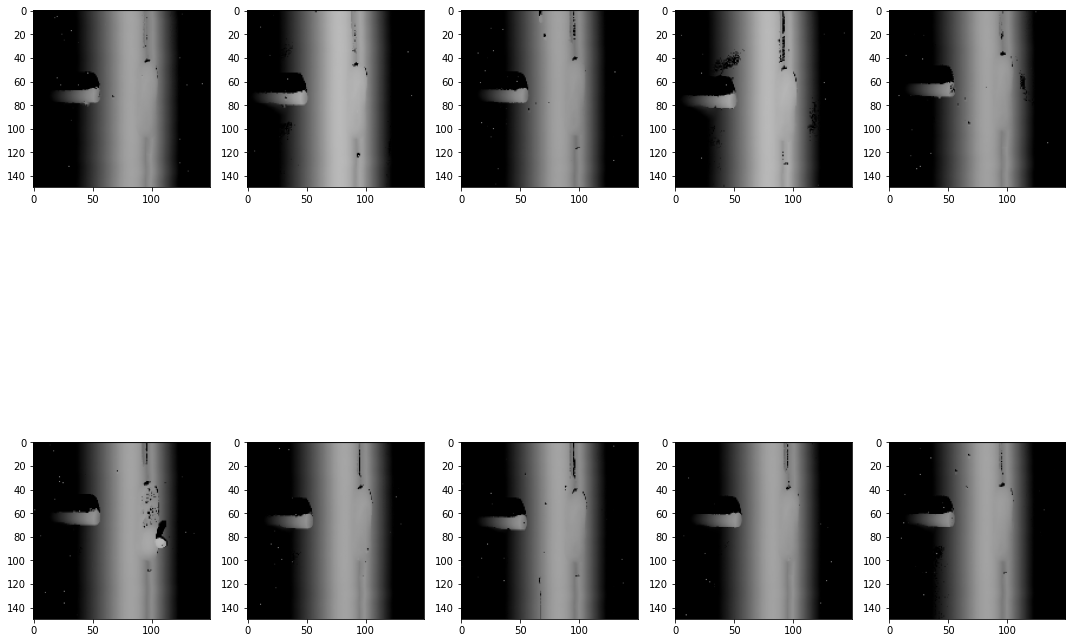

In [14]:
fig, ax=plt.subplots(2,5)
fig.set_size_inches(15,15)
l=0
for i in range(2):
    for j in range (5):
        l += 1
        ax[i,j].imshow(X_train[l])
        
plt.tight_layout()

# 4 - BASELINE MODEL - MLP DNN Classification without Convolution Feature Extraction Layers

In [22]:
# Baseline model without convolution feature extration - MLP classification
# Input size
img_width = 150 
img_height = 150
def model_0(learn_rate=0.001):
    model_0 = tf.keras.Sequential([
      tf.keras.layers.Flatten(name='flatten', input_shape = (img_width, img_height, 3)),
      tf.keras.layers.Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(2, activation='softmax', name='new_predictions')
      ])
    model_0.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return model_0

In [23]:
# fine tune the model using grid search and early stopping
checkpoint_path = './model_DNN_BASELINE.h5'
early_stop = EarlyStopping(monitor='accuracy', verbose=2, patience=5)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='accuracy', verbose=2, 
                     save_best_only=True)

learn_rate = [0.0001,0.01]
batch_size = [32,100]
epochs = [5]
classifier = KerasClassifier(build_fn=model_0)

param_grid = dict(epochs=epochs, batch_size=batch_size, learn_rate = learn_rate)
fit_model_0 = GridSearchCV(estimator = classifier, param_grid=param_grid, cv=5)

grid_result_0 = fit_model_0.fit(X_train,y_train, verbose=2, callbacks=[early_stop,model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/5

Epoch 1: accuracy improved from -inf to 0.82947, saving model to ./model_DNN_BASELINE.h5
19/19 - 1s - loss: 10.2143 - accuracy: 0.8295 - 1s/epoch - 71ms/step
Epoch 2/5

Epoch 2: accuracy did not improve from 0.82947
19/19 - 0s - loss: 4.9968 - accuracy: 0.8195 - 352ms/epoch - 19ms/step
Epoch 3/5

Epoch 3: accuracy improved from 0.82947 to 0.84934, saving model to ./model_DNN_BASELINE.h5
19/19 - 1s - loss: 2.2917 - accuracy: 0.8493 - 795ms/epoch - 42ms/step
Epoch 4/5

Epoch 4: accuracy improved from 0.84934 to 0.86755, saving model to ./model_DNN_BASELINE.h5
19/19 - 1s - loss: 1.7308 - accuracy: 0.8675 - 801ms/epoch - 42ms/step
Epoch 5/5

Epoch 5: accuracy improved from 0.86755 to 0.89404, saving model to ./model_DNN_BASELINE.h5
19/19 - 1s - loss: 1.3737 - accuracy: 0.8940 - 785ms/epoch - 41ms/step
5/5 [==============================] - 0s 8ms/step - loss: 1.2932 - accuracy: 0.8750
Epoch 1/5

Epoch 1: accuracy did not improve from 0.89404
19/19 - 1s - loss: 9.3760 - accuracy:

In [24]:
print("BASELNIE DNN model:")
print(grid_result_0.best_params_)
print(grid_result_0.best_estimator_)
print(grid_result_0.best_score_)

BASELNIE DNN model:
{'batch_size': 32, 'epochs': 5, 'learn_rate': 0.0001}
0.8928807973861694


In [25]:
model_0_final = load_model('./model_DNN_BASELINE.h5')
mdoel_0_final_train_evaluate = model_0_final.evaluate(X_train,y_train, verbose=0)
mdoel_0_final_test_evaluate = model_0_final.evaluate(X_test,y_test, verbose=0)
print("the BASELINE DNN model accuracy on training dataset is:", mdoel_0_final_train_evaluate[1])
print("the BASELINE DNN model accuracy on test dataset is:", mdoel_0_final_test_evaluate[1])

the BASELINE DNN model accuracy on training dataset is: 0.8928571343421936
the BASELINE DNN model accuracy on test dataset is: 0.8928571343421936


# 5 - Use a VGG16 model for Transfer Learning (pre-trained on ImageNet)
# Modify the top fully connected layers and output layer to GOOD/BAD weld classification application

In [15]:
# Input size
img_width = 150 
img_height = 150

In [16]:
# configure a VGG16 module with top layers disabled - include_top
model_vgg16 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
model_vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

# MODEL 1 - freeze all layers of VGG16, add fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 2 nodes and ‘softmax’ activation)

In [17]:
# freeze all layers of VGG16
for layer in model_vgg16.layers:
    layer.trainable = False
    
for i, layer in enumerate(model_vgg16.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [18]:
# VGG16 net, then add fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 2 nodes and ‘softmax’ activation)
# 2 nodes - 2 classes - GOOD/BAD outputs
def model_1(learn_rate=0.001):
    model_1 = tf.keras.Sequential([
      model_vgg16,
      tf.keras.layers.Flatten(name='flatten'),
      tf.keras.layers.Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(2, activation='softmax', name='new_predictions')
      ])
    model_1.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return model_1

In [19]:
# fine tune the model using grid search and early stopping
checkpoint_path = './model_vgg16_frozen.h5'
early_stop = EarlyStopping(monitor='accuracy', verbose=2, patience=5)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='accuracy', verbose=2, 
                     save_best_only=True)

learn_rate = [0.0001,0.01]
batch_size = [32,100]
epochs = [5]
classifier = KerasClassifier(build_fn=model_1)

param_grid = dict(epochs=epochs, batch_size=batch_size, learn_rate = learn_rate)
fit_model_1 = GridSearchCV(estimator = classifier, param_grid=param_grid, cv=5)

grid_result_1 = fit_model_1.fit(X_train,y_train, verbose=2, callbacks=[early_stop,model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/5

Epoch 1: accuracy improved from -inf to 0.86093, saving model to ./model_vgg16_frozen.h5
19/19 - 17s - loss: 3.0007 - accuracy: 0.8609 - 17s/epoch - 876ms/step
Epoch 2/5

Epoch 2: accuracy improved from 0.86093 to 0.90397, saving model to ./model_vgg16_frozen.h5
19/19 - 3s - loss: 0.8090 - accuracy: 0.9040 - 3s/epoch - 170ms/step
Epoch 3/5

Epoch 3: accuracy improved from 0.90397 to 0.92715, saving model to ./model_vgg16_frozen.h5
19/19 - 3s - loss: 0.5714 - accuracy: 0.9272 - 3s/epoch - 169ms/step
Epoch 4/5

Epoch 4: accuracy improved from 0.92715 to 0.94868, saving model to ./model_vgg16_frozen.h5
19/19 - 3s - loss: 0.4219 - accuracy: 0.9487 - 3s/epoch - 170ms/step
Epoch 5/5

Epoch 5: accuracy did not improve from 0.94868
19/19 - 3s - loss: 0.3616 - accuracy: 0.9487 - 3s/epoch - 158ms/step
5/5 [==============================] - 3s 619ms/step - loss: 0.4015 - accuracy: 0.9145
Epoch 1/5

Epoch 1: accuracy did not improve from 0.94868
19/19 - 6s - loss: 2.8765 - accuracy: 0.8

In [20]:
print("first model:")
print(grid_result_1.best_params_)
print(grid_result_1.best_estimator_)
print(grid_result_1.best_score_)

first model:
{'batch_size': 32, 'epochs': 5, 'learn_rate': 0.0001}
0.9511066555976868


In [21]:
model_1_final = load_model('./model_vgg16_frozen.h5')
mdoel_1_final_train_evaluate = model_1_final.evaluate(X_train,y_train, verbose=0)
mdoel_1_final_test_evaluate = model_1_final.evaluate(X_test,y_test, verbose=0)
print("the first model accuracy on training dataset is:", mdoel_1_final_train_evaluate[1])
print("the first model accuracy on test dataset is:", mdoel_1_final_test_evaluate[1])


the first model accuracy on training dataset is: 0.9563491940498352
the first model accuracy on test dataset is: 0.9365079402923584


# MODEL 2 - Only the last block (15:19) 4 layers are enabled to train. 
# Add fully connected layers

In [ ]:
# model 2: VGG16 top layer removed and add fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 2 nodes and ‘softmax’ activation)
for layer in model_vgg16.layers[:]:
     layer.trainable = False
for layer in model_vgg16.layers[15:19]: # only enable the last block (4 layers)
      layer.trainable = True
for i, layer in enumerate(model_vgg16.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
def model_2(learn_rate=0.001):
    model_2 = tf.keras.Sequential([
      model_vgg16,
      tf.keras.layers.Flatten(name='flatten'),
      tf.keras.layers.Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(2, activation='softmax', name='new_predictions')
      ])
    model_2.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return model_2


In [ ]:
# fine tune the model using grid search and early stopping
checkpoint_path = './model_vgg16_block5.h5'
early_stop = EarlyStopping(monitor='accuracy', verbose=2, patience=5)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='accuracy', verbose=2, 
                     save_best_only=True)

learn_rate = [0.0001,0.01]
batch_size = [32,100]
epochs = [5]
classifier_2 = KerasClassifier(build_fn=model_2)

param_grid = dict(epochs=epochs, batch_size=batch_size, learn_rate = learn_rate)
fit_model_2 = GridSearchCV(estimator = classifier_2, param_grid=param_grid, cv=5)

grid_result_2 = fit_model_2.fit(X_train,y_train, verbose=2, callbacks=[early_stop,model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/5

Epoch 1: accuracy improved from -inf to 0.83609, saving model to ./model_vgg16_block5.h5
19/19 - 6s - loss: 3.0485 - accuracy: 0.8361 - 6s/epoch - 294ms/step
Epoch 2/5

Epoch 2: accuracy improved from 0.83609 to 0.87252, saving model to ./model_vgg16_block5.h5
19/19 - 4s - loss: 0.9569 - accuracy: 0.8725 - 4s/epoch - 191ms/step
Epoch 3/5

Epoch 3: accuracy improved from 0.87252 to 0.90728, saving model to ./model_vgg16_block5.h5
19/19 - 4s - loss: 0.5907 - accuracy: 0.9073 - 4s/epoch - 190ms/step
Epoch 4/5

Epoch 4: accuracy improved from 0.90728 to 0.97185, saving model to ./model_vgg16_block5.h5
19/19 - 4s - loss: 0.4032 - accuracy: 0.9719 - 4s/epoch - 191ms/step
Epoch 5/5

Epoch 5: accuracy improved from 0.97185 to 0.98510, saving model to ./model_vgg16_block5.h5
19/19 - 4s - loss: 0.3036 - accuracy: 0.9851 - 4s/epoch - 190ms/step
5/5 [==============================] - 1s 147ms/step - loss: 0.4301 - accuracy: 0.9539
Epoch 1/5

Epoch 1: accuracy did not improve from 0.9851

In [ ]:
print("second model:")
print(grid_result_2.best_params_)
print(grid_result_2.best_estimator_)
print(grid_result_2.best_score_)

second model:
{'batch_size': 32, 'epochs': 5, 'learn_rate': 0.01}
1.0


In [ ]:
model_2_final = load_model('./model_vgg16_block5.h5')
mdoel_2_final_train_evaluate = model_2_final.evaluate(X_train,y_train, verbose=0)
mdoel_2_final_test_evaluate = model_2_final.evaluate(X_test,y_test, verbose=0)
print("the second model accuracy on training dataset is:", mdoel_2_final_train_evaluate[1])
print("the second model accuracy on test dataset is:", mdoel_2_final_test_evaluate[1])

the second model accuracy on training dataset is: 1.0
the second model accuracy on test dataset is: 0.988095223903656


# MODEL 3 - Enable all layers of VGG16 net, and add fully connected layers

In [ ]:
# model 3: VGG16 top layer removed and add fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 5 nodes and ‘softmax’ activation)
for layer in model_vgg16.layers[:]: 
      layer.trainable = True
for i, layer in enumerate(model_vgg16.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
def model_3(learn_rate=0.001):
    for layer in model_vgg16.layers[:]: # all layers enabled
      layer.trainable = True
    model_3 = tf.keras.Sequential([
      model_vgg16,
      tf.keras.layers.Flatten(name='flatten'),
      tf.keras.layers.Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(2, activation='softmax', name='new_predictions')
      ])
    model_3.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])
    return model_3

In [ ]:
# fine tune the model using grid search and early stopping
checkpoint_path = './model_vgg16_enable.h5'
early_stop = EarlyStopping(monitor='accuracy', verbose=2, patience=5)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='accuracy', verbose=2, 
                     save_best_only=True)

learn_rate = (0.0001,0.01)
batch_size = [32,100]
epochs = [5]
classifier = KerasClassifier(build_fn=model_3)

param_grid = dict(epochs=epochs, batch_size=batch_size, learn_rate = learn_rate)
fit_model_3 = GridSearchCV(estimator = classifier, param_grid=param_grid, cv=5)

grid_result_3 = fit_model_3.fit(X_train,y_train, verbose=2, callbacks=[early_stop,model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/5

Epoch 1: accuracy improved from -inf to 0.84603, saving model to ./model_vgg16_enable.h5
19/19 - 14s - loss: 3.4160 - accuracy: 0.8460 - 14s/epoch - 751ms/step
Epoch 2/5

Epoch 2: accuracy improved from 0.84603 to 0.89735, saving model to ./model_vgg16_enable.h5
19/19 - 8s - loss: 0.6914 - accuracy: 0.8974 - 8s/epoch - 440ms/step
Epoch 3/5

Epoch 3: accuracy did not improve from 0.89735
19/19 - 8s - loss: 0.5229 - accuracy: 0.8974 - 8s/epoch - 410ms/step
Epoch 4/5

Epoch 4: accuracy did not improve from 0.89735
19/19 - 8s - loss: 0.4795 - accuracy: 0.8974 - 8s/epoch - 410ms/step
Epoch 5/5

Epoch 5: accuracy did not improve from 0.89735
19/19 - 8s - loss: 0.4668 - accuracy: 0.8974 - 8s/epoch - 411ms/step
5/5 [==============================] - 1s 148ms/step - loss: 0.4776 - accuracy: 0.8750
Epoch 1/5

Epoch 1: accuracy did not improve from 0.89735
19/19 - 11s - loss: 2.4073 - accuracy: 0.8661 - 11s/epoch - 588ms/step
Epoch 2/5

Epoch 2: accuracy did not improve from 0.89735
19

In [ ]:
print("third model:")
print(grid_result_3.best_params_)
print(grid_result_3.best_estimator_)
print(grid_result_3.best_score_)

third model:
{'batch_size': 100, 'epochs': 5, 'learn_rate': 0.01}
1.0


In [ ]:
model_3_final = load_model('./model_vgg16_enable.h5')
mdoel_3_final_train_evaluate = model_3_final.evaluate(X_train,y_train, verbose=0)
mdoel_3_final_test_evaluate = model_3_final.evaluate(X_test,y_test, verbose=0)
print("the third model accuracy on training dataset is:", mdoel_3_final_train_evaluate[1])
print("the third model accuracy on test dataset is:", mdoel_3_final_test_evaluate[1])

the third model accuracy on training dataset is: 0.9973545074462891
the third model accuracy on test dataset is: 0.9920634627342224


# 6 - Conclusion:

## Good/Bad Weld image classification is explored using both DNN as baseline model, and a pretrained CNN model for transfer learning - VGG16 16 convolutional layers, developed by Visual Geometry Group (VGG) research lab at Oxford University.

## Baseline DNN model has fast training speed in gridsearch fine tuning compared with CNN. But it only achived relatively low accuracy of 89.29%. 

## From these 3 models evaluation of VGG16 transfer learning, it can be concluded that the last model which all blocks are enabled from the pre-trained VGG16 model has the overal best performance (Accuracy on test dataset is 99.21%, train - 99.74%)

## Model 1 has all layers in the pre-trained model frozen which could causing an influence from the weights in the pre-trained model, which could not be the best setup for the model combined. (test - 93.65%, train - 95.63%).

## Model 2 has only block5 convolution/pooling layers enabled from the VGG16 model is quite good, which had test accuracy of 98.81% and 100% on train dataset.

## Model 3 has all layers enabled from the pre-trained model, which should be giving us the most flexibility to perfectly train the model. 